## Looking at hydrographs and event delineations from [Kincaid et al., 2020](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2020WR027361). 

- ### Data publicly available here on HydroShare: https://www.hydroshare.org/resource/85fa32a11fbb49779033934a135f54ef/

- ### This larger dataset includes the 2014-2015 discharge and nitrate data from Vaughan, M. (2017). Vermont NEWRnet stations: 2014-2015 high-frequency DOC, nitrate, and discharge data, HydroShare, http://www.hydroshare.org/resource/faac1672244c407e9c9c8644c8211fd6.

- ### I downloaded on 05.02.24 and put it here in this directory /home/millieginty/OneDrive/git-repos/cQ_analysis/millar2021_R_partition_hysteresis

- ### The raw data file has discharge (q m3s), NO3, and SRP with timestamp and event start/end times for each watershed..

## I use the Kincaid 2020 events as delineated using HydRun with manual interventions.
 
 - ### Data were copied to this repo from the BREE OneDrive directory. One csv for each watershed, 2014-2018.
 - #### There was a storm (my storm #22) in the Kincaid Potash file that had an incorrect end year (7/25/2015 21:45 but was 7/25/2016 21:45). I changed the year.
 
 - ### I realized the event delineations are already in the raw Hydroshare data file! But the multipeak tag is not, nor the manual delineation marker, so I'm still glad this code processes and brings in the above event files.

### TO DO

- [ ] use multipeak tag from Kincaid event input

In [1]:
#################
# LOAD PACKAGES #
#################

library(tidyverse)
library(viridis)
library(dplyr)
library(lubridate)
library(glue)

###################
# SET DIRECTORIES #
###################

# Define the input and output directories

# For Kincaid data, input and output in separate directory
input_dir <- "/home/millieginty/OneDrive/git-repos/cQ_analysis/baseflow-rules-determinaton/data"
output_dir <- "/home/millieginty/OneDrive/git-repos/cQ_analysis/baseflow-rules-determinaton/output"

############################
# READ IN, TIDY, JOIN DATA #
############################

# Read in raw Hydroshare data csv from Kincaid et al 2020 found at https://www.hydroshare.org/resource/85fa32a11fbb49779033934a135f54ef/
# Downloaded on 05.02.24
allInputData15Min <- read.csv(file.path(input_dir, "hydroshare_rawData.csv")) %>%
  # Select and rename columns
  select(site, catch_area_km2, datetime = timestamp, condition, event_start, event_end, q_cms,
         NO3_mgNL, SRP_ugPL) %>%
  # drop NA
  drop_na(q_cms, NO3_mgNL, SRP_ugPL) %>%
  # Convert datetimes to POSIXct
  mutate(datetime = as.POSIXct(datetime, format = "%Y-%m-%d %H:%M:%S", tz = "EST"), 
        event_start = as.POSIXct(event_start, format = "%Y-%m-%d %H:%M:%S", tz = "EST"),
        event_end = as.POSIXct(event_end, format = "%Y-%m-%d %H:%M:%S", tz = "EST"))

# Construct the file name for event delineation based on Site definition
events_file <- paste("Events", Site, "2014to2018.csv", sep = "_")

# Read in the event delineation csv file
customEventDel <- read.csv(file.path(input_dir, "Event_delineations_2014-2018", events_file)) %>%
  # Add a storm ID
  mutate(storm_id = glue("storm_{row_number()}")) %>%
  # Select and rename columns
  select(storm_id, rainfall.start, start = HydRun.start, end = HydRun.end, multipeak.tag) %>%
  # Convert start and end datetimes to POSIXct
  mutate(start = as.POSIXct(start, format = "%m/%d/%Y %H:%M", tz = "EST"),
         end = as.POSIXct(end, format = "%m/%d/%Y %H:%M", tz = "EST"))

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: viridisLite



ERROR: Error in paste("Events", Site, "2014to2018.csv", sep = "_"): object 'Site' not found


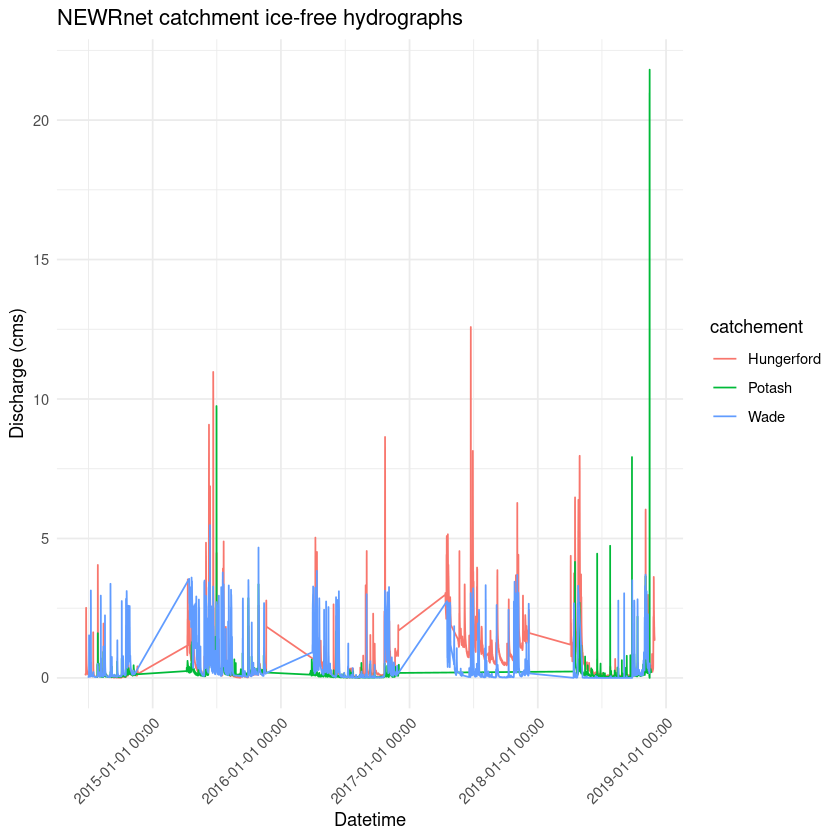

In [2]:
#######################
# PLOT THE HYDROGRAPH #
#######################

hydrograph_plot <- ggplot() +
  geom_line(data = allInputData15Min, aes(x = datetime, y = q_cms, color = site)) +
  theme_minimal() +
  labs(title = paste("NEWRnet catchment ice-free hydrographs", sep = " "),
       x = "Datetime",
       y = "Discharge (cms)",
       color = "catchement") +
  scale_x_datetime(date_labels = "%Y-%m-%d %H:%M", date_breaks = "1 year") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  theme(strip.text = element_text(size = 12)) 

# Print the modified plot
print(hydrograph_plot)

### Plot just the baseline flows (not separated from stormflow, just non event times)

# A tibble: 3 × 2
  site       average_q_cms
  <chr>              <dbl>
1 Hungerford         0.343
2 Potash             0.104
3 Wade               0.123


Warning message:
“Removed 5 rows containing missing values (`geom_line()`).”


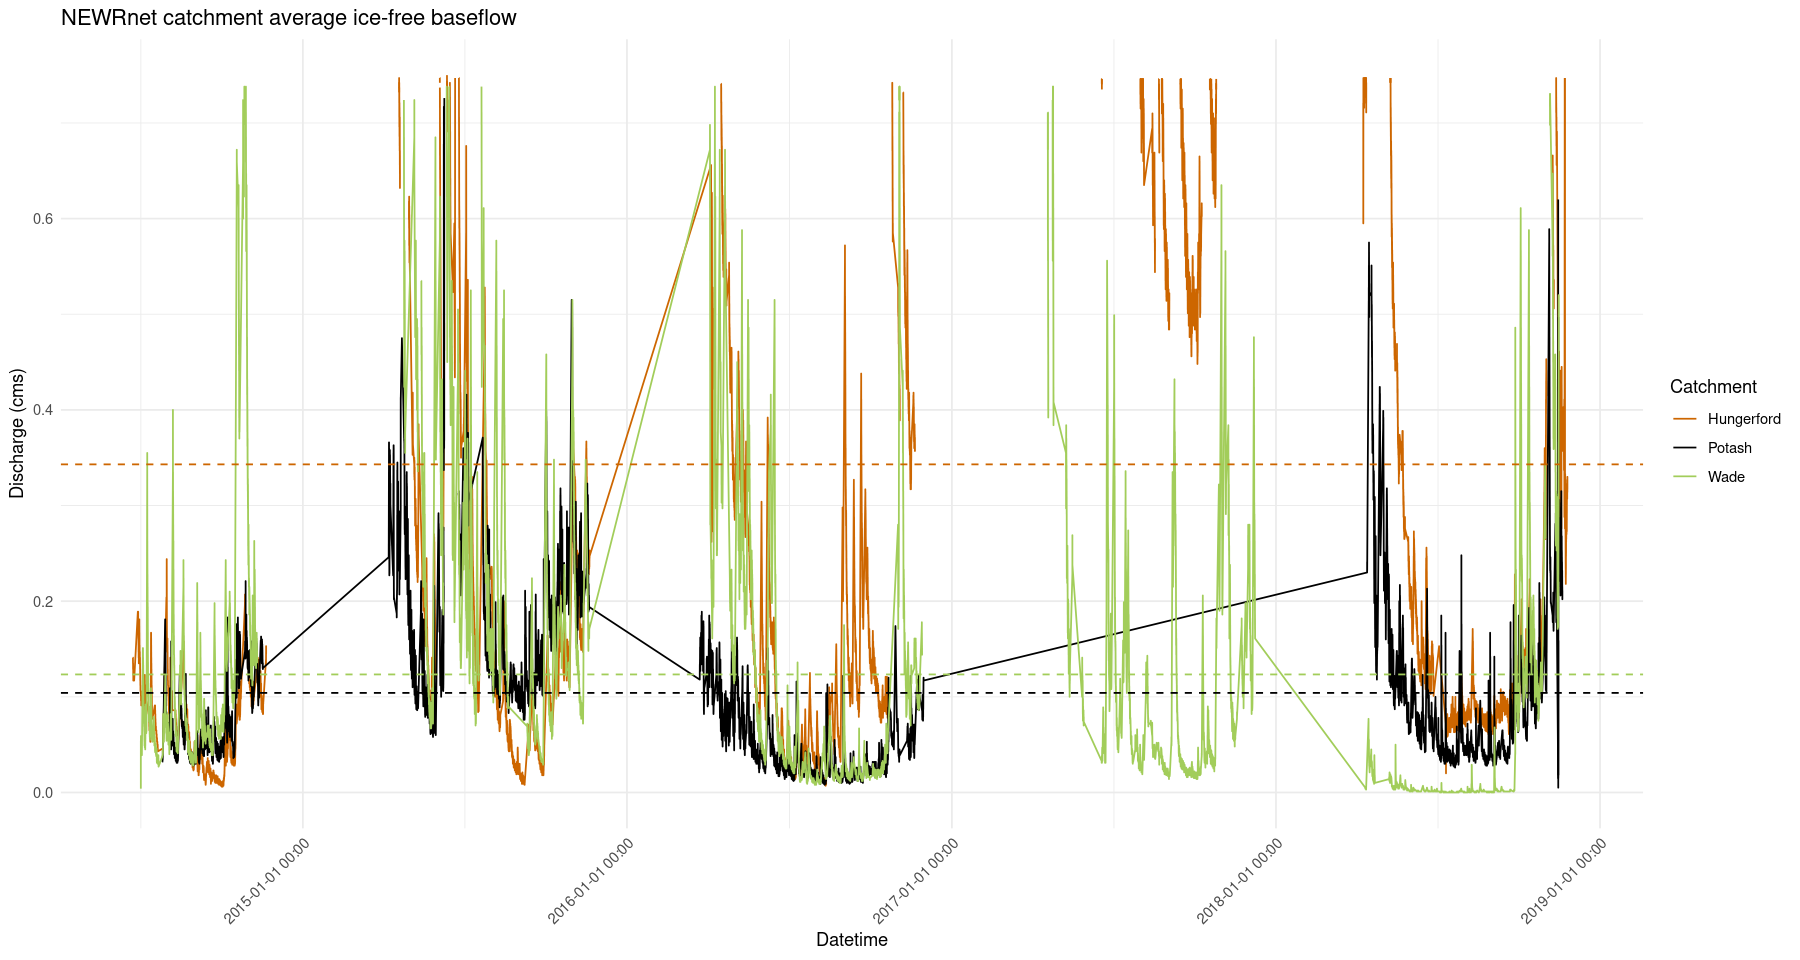

In [52]:
# Filter data to include only baseflow condition
baseflow_data <- allInputData15Min %>%
  filter(condition == "baseflow")

# Calculate the average q_cms for each site when the condition is baseflow
average_baseflow <- baseflow_data %>%
  group_by(site) %>%
  summarise(average_q_cms = mean(q_cms, na.rm = TRUE))

# Print the result
print(average_baseflow)

# Define custom colors for each site
site_colors <- c("Hungerford" = "darkorange3", "Potash" = "black", "Wade" = "darkolivegreen3")

# Plot the hydrograph for baseflow data
hydrograph_plot <- ggplot() +
  geom_line(data = baseflow_data, aes(x = datetime, y = q_cms, color = site)) +
  theme_minimal() +
  labs(title = "NEWRnet catchment average ice-free baseflow",
       x = "Datetime",
       y = "Discharge (cms)",
       color = "Catchment") +
  ylim(0, 0.75) + 
  scale_x_datetime(date_labels = "%Y-%m-%d %H:%M", date_breaks = "1 year") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  theme(strip.text = element_text(size = 12)) +
  scale_color_manual(values = site_colors)

# Add horizontal lines for average q_cms for each site
for(i in 1:nrow(average_baseflow)) {
  hydrograph_plot <- hydrograph_plot +
    geom_hline(yintercept = average_baseflow$average_q_cms[i], 
               color = site_colors[average_baseflow$site[i]], 
               linetype = "dashed")
}

# Print the modified plot
print(hydrograph_plot)

## Plot the full year hydrographs, since winterization in fall 2021

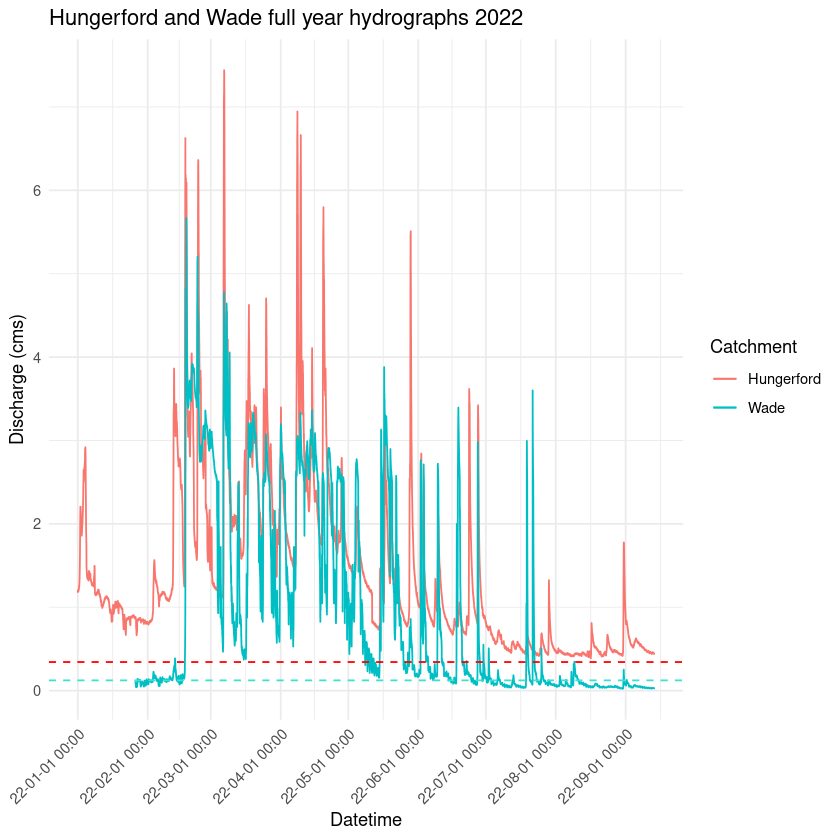

In [21]:
#################
# LOAD PACKAGES #
#################

library(tidyverse)
library(viridis)
library(dplyr)
library(lubridate)
library(caTools)  # for numerical integration
library(data.table) # for nearest join of q and ISCO data

###################
# SET DIRECTORIES #
###################

input_dir <- "~//OneDrive/git-repos//cQ_analysis/cond-hydrograph-separation/newrnet/data"
output_dir <- "cond-hydrograph-separation/newrnet/output/"

################
# READ IN DATA #
################

# read in the discharge data - Hungerford
hungerford_q <- read.csv(file.path(input_dir, "hungerford_2022_best_q.csv")) %>%
   mutate(timestamp = as.POSIXct(timestamp, format = "%m/%d/%Y %H:%M", tz = "EST"))

# read in the discharge data - Wade
wade_q <- read.csv(file.path(input_dir, "wade_2022_best_q_corr_MAT.csv")) %>%
  # Select and rename columns
   select(timestamp, q_cms = best_q) %>%
   mutate(timestamp = as.POSIXct(timestamp, format = "%m/%d/%Y %H:%M", tz = "EST"))

#######################
# PLOT THE HYDROGRAPH #
#######################

hydrograph_plot <- ggplot() +
  geom_line(data = hungerford_q, aes(x = timestamp, y = q_cms, color = "Hungerford")) +
  geom_line(data = wade_q, aes(x = timestamp, y = q_cms, color = "Wade")) +
  theme_minimal() +
  labs(title = "Hungerford and Wade full year hydrographs 2022",
       x = "Datetime",
       y = "Discharge (cms)",
       color = "Catchment") +
  scale_x_datetime(date_labels = "%Y-%m-%d %H:%M", date_breaks = "1 month") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  theme(strip.text = element_text(size = 20))

# Add horizontal lines for average q_cms for each site
hydrograph_plot <- hydrograph_plot +
  geom_hline(yintercept = 0.343, color = "red", linetype = "dashed") +
  geom_hline(yintercept = 0.123, color = "turquoise", linetype = "dashed")

# Print the modified plot
print(hydrograph_plot)